### Imports

In [1]:
print()
import numpy as np
import pandas as pd
import os

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))


import gym
import gym_anytrading
#import quantstats as qs



import matplotlib.pyplot as plt


Current working directory: /Users/pavan/Projects/gym-anytrading


In [2]:
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

In [3]:
df = pd.read_json("examples/result.json")

In [4]:
df_correct = pd.DataFrame(df)
df_correct[['Open', 'High', 'Low', 'Close', 'bidVolume', 'downTicks', 'upTicks', 'upVolume', 'downVolume', 'offerVolume']] = pd.DataFrame(df_correct.y.tolist(), index=df_correct.index)
df_correct = df_correct.drop_duplicates(["x"])

In [5]:
df_correct = df_correct.set_index("x")

In [6]:
df_correct = df_correct.drop('y', 1)

/var/folders/9y/qjy5hx1x4c39mh3vxgkfsr_c0000gn/T/ipykernel_26965/262562055.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_correct = df_correct.drop('y', 1)


In [7]:
df_correct = df_correct.sort_index()

In [8]:
df_goog = gym_anytrading.datasets.STOCKS_GOOGL.copy()

In [9]:
window_size = 100
start_index = window_size
end_index = len(df_correct)

gyme = gym.make(
    'stocks-v0',
    df = df_correct,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

In [13]:

start_index = window_size
end_index = len(df_correct)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df_correct,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

In [14]:
from stable_baselines3 import DQN
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=300000
            )


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 1685     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.456   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 4.1e+04  |
|    value_loss         | 9.19e+10 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1829     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.761   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 1.98e+05 |
|    value_loss      

policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpLnLstmPolicy', env)
model.learn(total_timesteps=300000, verbose=1)

In [15]:
env = env_maker()
observation = env.reset()
for i in range(300000):
    env.step(0)
while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': -2592141.0, 'total_profit': 1.0, 'position': 1, 'losers': 0, 'winners': 0, 'buys': 0, 'sells': 0}


### Plot Results

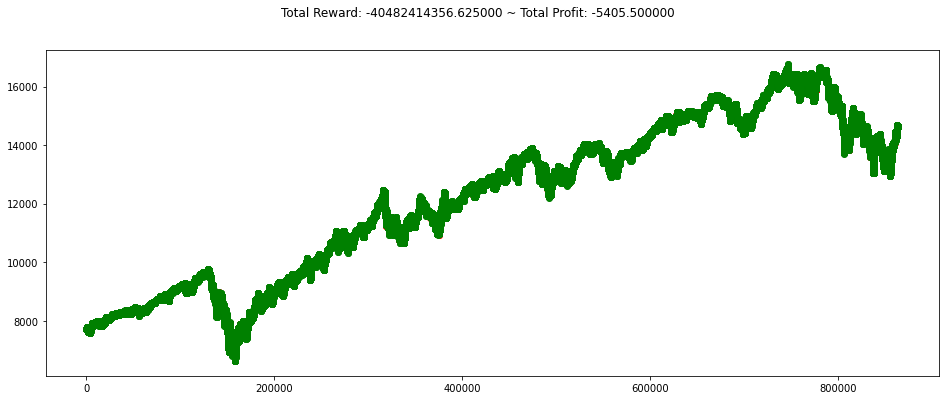

In [17]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')